In [319]:
# from google.colab import drive
# drive.mount('/content/drive')

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import warnings
from memory_profiler import memory_usage
import time

warnings.filterwarnings('ignore')

import pickle

In [469]:
import re #regular expression
import nltk #natural language toolkit
nltk.download('stopwords')
from nltk.util import pr #prints a sequence of items from starting point to ending point
stemmer = nltk.SnowballStemmer("english") # a stemmer is a function that produces variants of a root word, and a SnowballStemmer specifies the language in which it does that.
import string
from nltk.corpus import stopwords #stopwords are words that a search engine ignores eg. the, a, an, in, etc.
stopword=set(stopwords.words("english"))
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Win10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [470]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from keras.utils.np_utils import to_categorical
import tensorflow as tf

## Exploring the data

In [471]:
df = pd.read_csv('data/labeled_data.csv')

In [472]:
# delete irrelevant column
df.drop(['Unnamed: 0', 'hate_speech', 'offensive_language', 'neither', 'count'], inplace=True, axis=1)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Cleaning and processing text

In [473]:
for i in range(0,20):
  print(df["tweet"][i])

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"
!!!!!!"@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"
!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;
" &amp; you might not get ya bitch back &amp; thats that "
" @rhythmixx_ :hobbies inclu

In [474]:
#modal verbs & others
replace_list = {r"i'm": 'I am',
                r"I'm": 'I am',
                r"let’s": 'let us',
                r"can't": 'can not',
                r"mustn't": 'must not',
                r"shouldn't": 'should not',
                r"don't": 'do not',
                r"doesn't" : 'does not',
                r"cannot": 'can not',
                r"wouldn't": 'would not',
                r"shan’t": 'shall not'}

In [475]:
df['tweet'] = df['tweet'].apply(lambda x : str(x))
df['tweet'] = df['tweet'].apply(lambda x : x.lower())
df['tweet'] = df['tweet'].apply(lambda x : re.sub('@[^\s]+','', x))
for s in tqdm(replace_list):
  for idx,row in df.iterrows():
    df['tweet'][idx] = df['tweet'][idx].replace(s, replace_list[s])
for idx,row in tqdm(df.iterrows()):
    df['tweet'][idx] = df['tweet'][idx].replace('rt', "")
    df['tweet'][idx] = df['tweet'][idx].replace('&amp', "")

100%|██████████| 11/11 [01:49<00:00,  9.98s/it]
24783it [00:22, 1086.91it/s]


In [476]:
#cleaning and processing text using nltk and regular expressions
def clean_text(text):
    # text = str(text) #converting text to string
    # text = text.lower() # converting text to lower case
    text = re.sub('\[.*?/]', '', text) #removing punctuation marks
    text = re.sub('https://\S+www\.\S+', '', text) #reomving hyperlink format text
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) #removing numbers
    text = " ".join(text.split())
    #removing stopwords
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text = " ".join(text)
    text = text.strip()
    return text

df["tweet"] = df["tweet"].apply(clean_text)
df.head()

,class,tweet
0,2,woman complain cleaning house man always take ...
1,1,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,dawg ever fuck bitch sta cry confused shit
3,1,look like tranny
4,1,shit hear might true might faker bitch told ya


In [477]:
for i in range(0,20):
  print(df["tweet"][i])

woman complain cleaning house man always take trash
boy dats coldtyga dwn bad cuffin dat hoe place
dawg ever fuck bitch sta cry confused shit
look like tranny
shit hear might true might faker bitch told ya
shit blows meclaim faithful somebody still fucking hoes
sit hate another bitch got much shit going
cause I tired big bitches coming us skinny
might get ya bitch back thats
hobbies include fighting mariam bitch
keeks bitch curves everyone lol walked conversation like smh
murda gang bitch gang land
hoes smoke losers yea go ig
bad bitches thing like
bitch get
bitch nigga miss
bitch plz whatever
bitch love
bitches get cut everyday b
black bottle bad bitch


## Model Selection

In [478]:
X = np.array(df['tweet'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [479]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19826,)
(19826,)
(4957,)
(4957,)


In [480]:
tweet_tokenizer = TweetTokenizer() 
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = tweet_tokenizer.tokenize,
                             ngram_range=(1, 2),
                             max_df=0.5,
                             min_df=2, 
                             max_features = 1000)

In [481]:
X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()

In [482]:
model_performance = {}
model_name = []
matrix = []
matrix_plot = []
accur_score = []
memor_usage = []
time_taken_model = []


outputs = []
tweets = []
mod_name = []
test_tweets = ["He is a true hero, life saver and good man!",
               "As a woman you shouldn't complain about cleaning up your house.",
               "I can not just sit up and HATE on another bitch .. I got too much shit going on!",
               "Keeks is a bitch she curves everyone "" lol I walked into a conversation like this. Smh"]


### 1. Random Forest

              precision    recall  f1-score   support

           0       0.50      0.21      0.30       290
           1       0.94      0.93      0.94      3832
           2       0.75      0.94      0.83       835

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.69      4957
weighted avg       0.88      0.89      0.88      4957



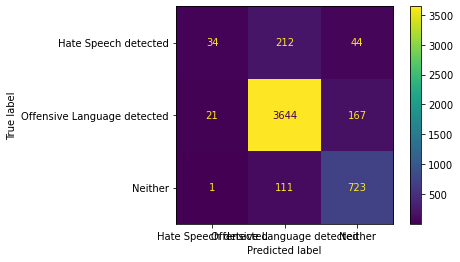

In [483]:
rf = RandomForestClassifier(n_estimators= 500,
                                  min_samples_split= 20,
                                  min_samples_leaf= 2,
                                  max_features= 'auto',
                                  max_depth= None,
                                  bootstrap= False)
start_time = time.time()
rf.fit(X_train_bow, y_train)
end_time = time.time()
time_taken = end_time - start_time
predictions = rf.predict(X_test_bow)
conf_matrix = confusion_matrix(y_test, predictions)
ac_score = accuracy_score(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                        display_labels = ["Hate Speech detected",
                                                        "Offensive Language detected",
                                                        "Neither"])
fig, ax = plt.subplots(figsize=(6,4))
cm_display.plot(ax=ax)

model_name.append('Random Forest Classifier')
matrix.append(conf_matrix)
accur_score.append(ac_score)
time_taken_model.append(time_taken)
print (class_report)


In [484]:
for tweet in test_tweets:
    df1 = vectorizer.transform([tweet]).toarray()
    if(rf.predict(df1) == 0):
        output = "Hate Speech detected"
    elif(rf.predict(df1) == 1):
        output = "Offensive Language detected"
    elif(rf.predict(df1) == 2):
        output = "Neither"
    tweets.append(tweet)
    outputs.append(output)
    mod_name.append('Random Forest')

### 2. Logistic Regression

              precision    recall  f1-score   support

           0       0.46      0.19      0.27       290
           1       0.92      0.94      0.93      3832
           2       0.78      0.86      0.82       835

    accuracy                           0.89      4957
   macro avg       0.72      0.67      0.68      4957
weighted avg       0.87      0.89      0.88      4957



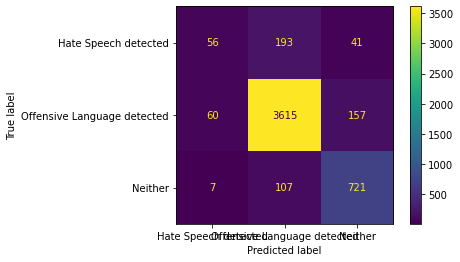

In [485]:
lr = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)
start_time = time.time()
lr.fit(X_train_bow, y_train)
end_time = time.time()
time_taken = end_time - start_time
predictions = lr.predict(X_test_bow)
conf_matrix = confusion_matrix(y_test, predictions)
ac_score = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                        display_labels = ["Hate Speech detected",
                                                        "Offensive Language detected",
                                                        "Neither"])
fig, ax = plt.subplots(figsize=(6,4))
cm_display.plot(ax=ax)

model_name.append('Logistic Regression')
matrix.append(conf_matrix)
accur_score.append(ac_score)
time_taken_model.append(time_taken)
print (class_report)

In [486]:
for tweet in test_tweets:
    df1 = vectorizer.transform([tweet]).toarray()
    if(lr.predict(df1) == 0):
        output = "Hate Speech detected"
    elif(lr.predict(df1) == 1):
        output = "Offensive Language detected"
    elif(lr.predict(df1) == 2):
        output = "Neither"
    tweets.append(tweet)
    outputs.append(output)
    mod_name.append('Logistic Regression')

### 3. Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.30      0.35      0.32       290
           1       0.91      0.91      0.91      3832
           2       0.78      0.74      0.76       835

    accuracy                           0.85      4957
   macro avg       0.66      0.67      0.66      4957
weighted avg       0.85      0.85      0.85      4957



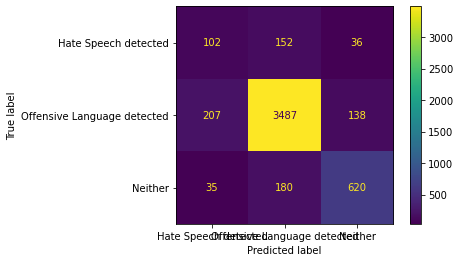

In [487]:
dtc = DecisionTreeClassifier()
start_time = time.time()
dtc.fit(X_train_bow, y_train)
end_time = time.time()
time_taken = end_time - start_time
predictions = dtc.predict(X_test_bow)
conf_matrix = confusion_matrix(y_test, predictions)
ac_score = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                        display_labels = ["Hate Speech detected",
                                                        "Offensive Language detected",
                                                        "Neither"])
fig, ax = plt.subplots(figsize=(6,4))
cm_display.plot(ax=ax)

model_name.append('Decision Tree Classifier')
matrix.append(conf_matrix)
accur_score.append(ac_score)
time_taken_model.append(time_taken)
print (class_report)

In [488]:
for tweet in test_tweets:
    df1 = vectorizer.transform([tweet]).toarray()
    if(dtc.predict(df1) == 0):
        output = "Hate Speech detected"
    elif(dtc.predict(df1) == 1):
        output = "Offensive Language detected"
    elif(dtc.predict(df1) == 2):
        output = "Neither"
    tweets.append(tweet)
    outputs.append(output)
    mod_name.append('Logistic Regression')

### 4. Ada Boost Classifier

              precision    recall  f1-score   support

           0       0.50      0.21      0.30       290
           1       0.94      0.93      0.94      3832
           2       0.75      0.94      0.83       835

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.69      4957
weighted avg       0.88      0.89      0.88      4957



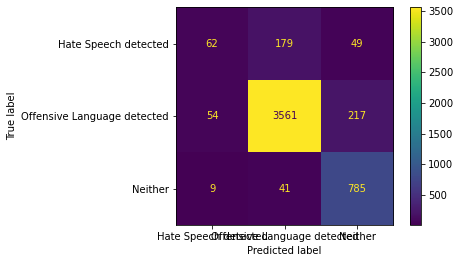

In [489]:
ada = AdaBoostClassifier(n_estimators=100)
start_time = time.time()
ada.fit(X_train_bow, y_train)
end_time = time.time()
time_taken = end_time - start_time
predictions = ada.predict(X_test_bow)
conf_matrix = confusion_matrix(y_test, predictions)
ac_score = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                        display_labels = ["Hate Speech detected",
                                                        "Offensive Language detected",
                                                        "Neither"])
fig, ax = plt.subplots(figsize=(6,4))
cm_display.plot(ax=ax)

model_name.append('AdaBoost Classifier')
matrix.append(conf_matrix)
accur_score.append(ac_score)
time_taken_model.append(time_taken)
print (class_report)

In [490]:
for tweet in test_tweets:
    df1 = vectorizer.transform([tweet]).toarray()
    if(ada.predict(df1) == 0):
        output = "Hate Speech detected"
    elif(ada.predict(df1) == 1):
        output = "Offensive Language detected"
    elif(ada.predict(df1) == 2):
        output = "Neither"
    tweets.append(tweet)
    outputs.append(output)
    mod_name.append('AdaBoost Classifier')

### 5. LSTM

Epoch 1/20
78/78 [==============================] - 57s 656ms/step - loss: 0.3254 - accuracy: 0.8106 - val_loss: 0.2036 - val_accuracy: 0.8894
Epoch 2/20
78/78 [==============================] - 51s 659ms/step - loss: 0.1872 - accuracy: 0.8950 - val_loss: 0.1894 - val_accuracy: 0.8856
Epoch 3/20
78/78 [==============================] - 54s 690ms/step - loss: 0.1569 - accuracy: 0.9097 - val_loss: 0.1951 - val_accuracy: 0.8864
Epoch 4/20
78/78 [==============================] - 52s 672ms/step - loss: 0.1364 - accuracy: 0.9217 - val_loss: 0.2158 - val_accuracy: 0.8884
Epoch 5/20
78/78 [==============================] - 53s 677ms/step - loss: 0.1202 - accuracy: 0.9308 - val_loss: 0.2330 - val_accuracy: 0.8842
Epoch 6/20
78/78 [==============================] - 52s 661ms/step - loss: 0.1075 - accuracy: 0.9374 - val_loss: 0.2421 - val_accuracy: 0.8775
Epoch 7/20
78/78 [==============================] - 52s 670ms/step - loss: 0.0977 - accuracy: 0.9431 - val_loss: 0.2678 - val_accuracy: 0.8818

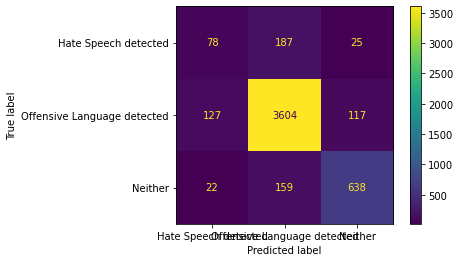

In [491]:
# mem_usage = memory_usage(model.fit(X_train_bow, y_train))
max_words = 2000
tokenizer = Tokenizer(num_words = max_words,
                filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~',
                split = ' ',
                lower = True)

tokenizer.fit_on_texts(df['tweet'].values)
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X)
y = to_categorical(df['class'], num_classes = 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 8000, output_dim = 128, input_length = X_train.shape[1]))
model_lstm.add(SpatialDropout1D(0.1))
model_lstm.add(LSTM(256, dropout = 0.2, recurrent_dropout = 0.1))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(3, activation = 'softmax'))
model_lstm.compile(loss ='binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
            metrics = ['accuracy'])
start_time = time.time()
history = model_lstm.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test), 
                    epochs = 20,
                    batch_size = 256)
end_time = time.time()
time_taken = end_time - start_time
score, ac_score = model_lstm.evaluate(X_test, y_test, verbose = 2, batch_size = 128)
lstm_pred = model_lstm.predict(X_test)
predictions = np.argmax(lstm_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                        display_labels = ["Hate Speech detected",
                                                        "Offensive Language detected",
                                                        "Neither"])
fig, ax = plt.subplots(figsize=(6,4))
cm_display.plot(ax=ax)

model_name.append('LSTM')
matrix.append(conf_matrix)
accur_score.append(ac_score)
time_taken_model.append(time_taken)
print (class_report)


In [492]:
for tweet in test_tweets:
    twt = tokenizer.texts_to_sequences(tweet)
    twt = pad_sequences(twt, maxlen = 128)
    sentiment = model_lstm.predict(twt)[0]

    if(np.argmax(sentiment) == 0):
        output = "Hate Speech detected"
    elif (np.argmax(sentiment) == 1):
        output = "Offensive Language detected"
    elif (np.argmax(sentiment) == 2):
        output = "Neither"
    tweets.append(tweet)
    outputs.append(output)
    mod_name.append('LSTM')

3/3 [==============================] - 1s 192ms/step


In [493]:
model_performance = {'Model Name': model_name,
                     'Accuracy Score':accur_score,
                     'Confusion Matrix': matrix,
                     'Time Taken':time_taken_model}
real_world_perfomance = {'Tweet':tweets,
                          'Model Name': mod_name,
                          'Output': outputs}
                          

In [494]:
pd.DataFrame(model_performance)

,Model Name,Accuracy Score,Confusion Matrix,Time Taken
0,Random Forest Classifier,0.887835,"[[34, 212, 44], [21, 3644, 167], [1, 111, 723]]",544.539804
1,Logistic Regression,0.886020,"[[56, 193, 41], [60, 3615, 157], [7, 107, 721]]",0.527997
2,Decision Tree Classifier,0.849102,"[[102, 152, 36], [207, 3487, 138], [35, 180, 6...",29.706999
3,AdaBoost Classifier,0.889248,"[[62, 179, 49], [54, 3561, 217], [9, 41, 785]]",75.716456
4,LSTM,0.871495,"[[78, 187, 25], [127, 3604, 117], [22, 159, 638]]",1013.914154


In [495]:
pd.DataFrame(real_world_perfomance)

,Tweet,Model Name,Output
0,"He is a true hero, life saver and good man!",Random Forest,Neither
1,As a woman you shouldn't complain about cleani...,Random Forest,Neither
2,I can not just sit up and HATE on another bitc...,Random Forest,Offensive Language detected
3,Keeks is a bitch she curves everyone lol I wa...,Random Forest,Offensive Language detected
4,"He is a true hero, life saver and good man!",Logistic Regression,Offensive Language detected
5,As a woman you shouldn't complain about cleani...,Logistic Regression,Offensive Language detected
6,I can not just sit up and HATE on another bitc...,Logistic Regression,Offensive Language detected
7,Keeks is a bitch she curves everyone lol I wa...,Logistic Regression,Offensive Language detected
8,"He is a true hero, life saver and good man!",Logistic Regression,Neither
9,As a woman you shouldn't complain about cleani...,Logistic Regression,Offensive Language detected


In [501]:
df_perf = pd.DataFrame(real_world_perfomance)
df_perf.to_csv('data/models_performance.csv', sep = ',',index = False)

## *Model Deployment*

In [496]:
## A function that creates pickle files of the models for deployment purposes
# Inputs:       models - a list of models
#               mod_names - a list of models
#               vectorizer - countvectorizer 
#               test_tweets - a list of tweets to test the performance of the models           
def deployment(models, mod_names, vectorizer, tokenizer):
    for model in models:
        # pickling model
        i = models.index(model)
        address = 'app/models/'+ mod_names[i] + '.pkl'
        pickle.dump(model, open(address, 'wb'))
    #pickling vectorizer
    pickle.dump(vectorizer, open('app/models/vectorizer.pkl', 'wb'))
    #pickling tokenizer
    pickle.dump(tokenizer, open('app/models/tokenizer.pkl', 'wb'))

In [497]:
models = [rf, lr, dtc, ada, model_lstm]
mod_names = ['Random_Forest_Classifier',
            'Logistic_Regression_Classifier',
            'Decision_Tree_Classifier',
            'AdaBoost_Classifier',
            'LSTM']

In [498]:
# deployment
deployment(models, mod_names, vectorizer, tokenizer)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\spatial_dropout1d
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 03:42:51         3349
metadata.json                                  2023-02-27 03:42:51           64
variables.h5               